In [ ]:
!pwd

In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import pafy
import time
import copy
from scipy.spatial import distance
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from models.keras_ssd512 import ssd_512
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set the image size.
img_height = 512
img_width = 512

In [3]:
model = ssd_512(image_size=(img_height, img_width, 3),
                n_classes=20,
                mode='inference',
                l2_regularization=0.0005,
                scales=[0.07, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05], # The scales for MS COCO are [0.04, 0.1, 0.26, 0.42, 0.58, 0.74, 0.9, 1.06]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                two_boxes_for_ar1=True,
                steps=[8, 16, 32, 64, 128, 256, 512],
                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.5,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)

### Load the pre-trained SSD weights

In [4]:
weights_path = 'VGG_VOC0712_SSD_512x512_iter_120000.h5'

model.load_weights(weights_path, by_name=True)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

### Test image

In [5]:
img_path = 'examples/test.jpg'

img = cv2.imread(img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
orig_img = np.copy(img)
img = cv2.resize(img,(img_height, img_width))
img = np.expand_dims(img,0)

In [6]:
# %%time
result = model.predict(img)
confidence_threshold = 0.5

result_thresh = [result[k][result[k,:,1] > confidence_threshold] for k in range(result.shape[0])]
# print(result_thresh[0])
width_fix_factor = orig_img.shape[1]/img_width
height_fix_factor = orig_img.shape[0]/img_height

current: [(933, 504), (593, 511), (322, 490), (751, 405), (1112, 514), (101, 426)]
history: {10: [(933, 504)], 11: [(593, 511)], 12: [(322, 490)], 13: [(751, 405)], 14: [(1112, 514)], 15: [(101, 426)]}


(-0.5, 1197.5, 784.5, -0.5)

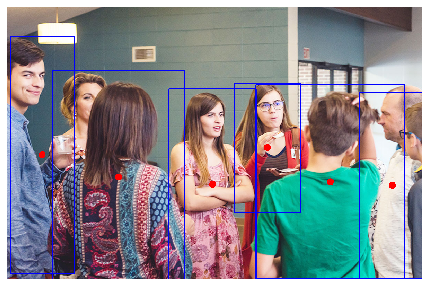

In [7]:
classes = ['background','aeroplane','bicycle','bird','boat','bottle','bus','car','cat',
           'chair','cow','diningtable','dog','horse','motorbike','person','pottedplant',
           'sheep','sofa','train','tvmonitor']

track_history = {}
current_centroids = []

img = cv2.imread(img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

idx = 10
for r in result_thresh[0]:
    if r[0] == 15: # person
        xmin = int(r[2] * width_fix_factor)
        ymin = int(r[3] * height_fix_factor)
        xmax = int(r[4] * width_fix_factor)
        ymax = int(r[5] * height_fix_factor)
        cent = (int(np.mean((xmin,xmax))),int(np.mean((ymin,ymax))))
        tl = (xmin,ymin)
        br = (xmax,ymax)
        cv2.rectangle(img,tl,br,(0,0,255),thickness=2)
        current_centroids.append(cent)
        
#         if not track_history: # if empty
        track_history[idx] = [cent]
#         else:

        idx += 1
        
print('current: {}'.format(current_centroids))
print('history: {}'.format(track_history))

for centroid in current_centroids:
    cv2.circle(img,centroid,10,(255,0,0),cv2.FILLED)
plt.figure(figsize=(10,5))
plt.imshow(img)
plt.axis('off')

In [ ]:
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

In [ ]:
tracking_dict = {}
center_tracking = []

In [ ]:
center_tracking.append((4,5))

In [ ]:
center_tracking

In [ ]:
tracking_dict[1] = center_tracking

In [ ]:
tracking_dict

In [64]:
sample_list = [(3,7),(10,10),(15,15)]
sample_dict = {1:[(2,3),(3,6)],2:[(8,3),(8,6)],3:[(4,3),(4,6)]}

In [65]:
sample_dict_temp = copy.deepcopy(sample_dict)
print(sample_dict_temp)
print(sample_dict)
for cent in sample_list:
    min_dist = min_dist_thresh
    min_label = None
    for label,pos in sample_dict.items():
        dist = distance.euclidean(cent,pos[-1])
        if dist<min_dist:
            min_dist = dist
            min_label = label
    sample_dict_temp[min_label].append(cent)

{1: [(2, 3), (3, 6)], 2: [(8, 3), (8, 6)], 3: [(4, 3), (4, 6)]}
{1: [(2, 3), (3, 6)], 2: [(8, 3), (8, 6)], 3: [(4, 3), (4, 6)]}


In [66]:
print(sample_dict_temp) # should not be altered
print(sample_dict)

{1: [(2, 3), (3, 6), (3, 7)], 2: [(8, 3), (8, 6), (10, 10), (15, 15)], 3: [(4, 3), (4, 6)]}
{1: [(2, 3), (3, 6)], 2: [(8, 3), (8, 6)], 3: [(4, 3), (4, 6)]}


In [10]:
a = ['a','b','c']

In [11]:
a.remove('b')

In [12]:
a

['a', 'c']

In [26]:
current_centroids

[(356, 143), (855, 483)]

In [42]:
dd = (int(np.mean((5,2))),int(np.mean((3,4))))

In [43]:
dd

(3, 3)

In [77]:
aa = {'2':'d'}

In [79]:
bb = {}

In [81]:
if bb:
    print('not empty')
else:
    print('empty')

empty


In [84]:
frame_count = 0
skip_frame = 10
min_dist_thresh = 50
url = 'https://www.youtube.com/watch?v=KMJS66jBtVQ'
pa = pafy.new(url)
play = pa.getbest(preftype='webm')
cap = cv2.VideoCapture(play.url)
confidence_threshold = 0.5



if (cap.isOpened() == False):
    print('cannot read a video')
    
track_history = {}
archive = {}
idx = 0
while cap.isOpened():
    ret,frame = cap.read()
    
    if ret == True:
        frame = np.asarray(frame)
#         orig_frame = np.copy(frame)
        frame = cv2.resize(frame,(img_height,img_width)) #resize for SSD
        frame = np.expand_dims(frame,0)
        
        if frame_count % skip_frame == 0: #every 10 frames
            current_centroids = [] #reset current centroid list at every frame
            
            ## if track_history is empty 
            if not track_history:
                result = model.predict(frame)
                results = [result[k][result[k,:,1] > confidence_threshold] for k in range(result.shape[0])]
                ## at least one person on the scene
                
                for r in results[0]:
                    if r[0] == 15: # person
                        xmin = int(r[2]*width_fix_factor)
                        ymin = int(r[3]*height_fix_factor)
                        xmax = int(r[4]*width_fix_factor)
                        ymax = int(r[5]*height_fix_factor)
                        centroid = (int(np.mean((xmin,xmax))),int(np.mean((ymin,ymax))))
#                         print('when empty {}'.format(centroid)) #######################################
                        tl = (xmin,ymin)
                        br = (xmax,ymax)
#                         cv2.rectangle(orig_frame,tl,br,(0,0,255),thickness=2)
                        track_history[idx] = [centroid] # add the list of positions
                        idx += 1
#                 print('when empty dict {}'.format(track_history)) #######################################
            
            ## after persons are detected and track_history is created
            else:
                result = model.predict(frame)
                results = [result[k][result[k,:,1] > confidence_threshold] for k in range(result.shape[0])]
    
                for r in results[0]:
                    if r[0] == 15: # person
                        xmin = int(r[2]*width_fix_factor)
                        ymin = int(r[3]*height_fix_factor)
                        xmax = int(r[4]*width_fix_factor)
                        ymax = int(r[5]*height_fix_factor)
                        centroid = (int(np.mean((xmin,xmax))),int(np.mean((ymin,ymax))))
                        tl = (xmin,ymin)
                        br = (xmax,ymax)
#                         cv2.rectangle(orig_frame,tl,br,(0,0,255),thickness=2)
                        current_centroids.append(centroid)
                print('for frame {}: {}'.format(frame_count,current_centroids))#######################################

                ## compare and update
                current_centroids_temp = copy.deepcopy(current_centroids)
                track_history_temp = copy.deepcopy(track_history)
                track_history_key_temp = copy.deepcopy(list(track_history.keys()))
                
#                 if len(current_centroids_temp) == len(track_history_temp): ## normal situation
                    
                ## original stays unchanged therefore use for looping
                for cent in current_centroids:
                    min_dist = min_dist_thresh
                    min_label = None 
                    for label,pos in track_history.items():
                        dist = distance.euclidean(cent,pos[-1])
                        if dist<min_dist:
                            min_dist = dist
                            min_label = label 
                            
                    # for same label centroid
                    if min_label is not None:
                        track_history_temp[min_label].append(cent) ## update the history by appending
                        current_centroids_temp.remove(cent)
                        track_history_key_temp.remove(min_label)
                    else: #min_label is NONE --> NEW VALUE
                        idx += 1
                        track_history_temp[idx] = [cent]
                        current_centroids_temp.remove(cent)

                if track_history_key_temp:
                    for left_over in track_history_key_temp:     
                        track_history_temp[left_over].append(track_history_temp[left_over][-1]) 
                        
                if current_centroids_temp: #if current centroid temp is not empty
                    idx += 1
                    for left_over in current_centroids_temp:
                        track_history_temp[idx] = left_over ## add new objects to the track
                   

                track_history = track_history_temp

                
#                 elif len(current_centroids) > len(track_history): ## new person comes in the scene
#                     for cent in current_centroids:
#                         min_dist = min_dist_thresh
#                         min_label = None
#                         for label,pos in track_history_temp.items():
#                             dist = distance.euclidean(cent,pos[-1])
#                             if dist<min_dist:
#                                 min_dist = dist
#                                 min_label = label
#                         track_history[min_label].append(cent) ## update the history
#                         current_centroids_temp.remove(cent)
#                     for left_over in current_centroids_temp:
#                         track_history[idx+1] = left_over ## add new objects to the track
                
#                 else: # object hidden or exit
#                     for cent in current_centroids:
#                         min_dist = min_dist_thresh
#                         min_label = None
#                         for label,pos in track_history_temp.items():
#                             dist = distance.euclidean(cent,pos[-1])
#                             if dist<min_dist:
#                                 min_dist = dist
#                                 min_label = label
#                         track_history[min_label].append(cent) ## update the history
#                         track_history_key_temp.remove(min_label)
#                     for left_over in track_history_key_temp:
#                         track_history[left_over].append(track_history[left_over][-1])
                print('for frame {} dict: {}'.format(frame_count,track_history))#######################################
                print('\n')

#             print(track_history)        
# current: [(933, 504), (593, 511), (322, 490), (751, 405), (1112, 514), (101, 426)]
# history: {0: (933, 504), 1: (593, 511), 2: (322, 490), 3: (751, 405), 4: (1112, 514), 5: (101, 426)}  
        
#         cv2.imshow('frame',frame)
        frame_count += 1
        if cv2.waitKey(1) & 0xff == ord('q'):
            break
        
        
        
        
    else:
        break
# cv2.destroyAllWindows()
cap.release()
# out.release() 


'''
need to work on the archive
'''

for frame 10: [(356, 154), (272, 206)]
for frame 10 dict: {0: [(356, 154), (356, 154)], 1: [(271, 206), (272, 206)]}


for frame 20: [(356, 154), (272, 206)]
for frame 20 dict: {0: [(356, 154), (356, 154), (356, 154)], 1: [(271, 206), (272, 206), (272, 206)]}


for frame 30: [(356, 154), (272, 206)]
for frame 30 dict: {0: [(356, 154), (356, 154), (356, 154), (356, 154)], 1: [(271, 206), (272, 206), (272, 206), (272, 206)]}


for frame 40: [(356, 143), (855, 483)]
for frame 40 dict: {0: [(356, 154), (356, 154), (356, 154), (356, 154), (356, 143)], 1: [(271, 206), (272, 206), (272, 206), (272, 206), (272, 206)], 3: [(855, 483)]}


for frame 50: [(334, 158), (839, 490)]
for frame 50 dict: {0: [(356, 154), (356, 154), (356, 154), (356, 154), (356, 143), (334, 158)], 1: [(271, 206), (272, 206), (272, 206), (272, 206), (272, 206), (272, 206)], 3: [(855, 483), (839, 490)]}


for frame 60: [(335, 154), (733, 519), (619, 123), (773, 471)]
for frame 60 dict: {0: [(356, 154), (356, 154), (356, 15

KeyboardInterrupt: 

In [33]:
current_centroids

[(356, 143), (855, 483)]